# Aggregate extraced time across multiple traces

1. Input parameters: directory with JSON traces, trace name pattern, (multiple) event patterns.  
   a. In trace name pattern, use one group for the varying parameter value (MBS).
2. For each event pattern, extract event time from all traces one by one using parseOneTrace script.
3. Aggregate values into one DF along with the varying parameter value extracted from the trace filename.


In [1]:
import os
import pandas as pd
import subprocess
import re
import matplotlib
from matplotlib import pyplot as plt

## Set input parameters

In [11]:
logdir = 'logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729'
trace_name_pattern = 'dnnmark_mouse.cont_conf_convolution_block_shape([0-9\-]+)_bs([0-9]+)_algospytorch_iter10_00\.json'
# event_patterns = ['.*batchnormalization.*','.*sgemm.*', '.*convolution.*']

## Read trace files

In [19]:
list_command = "ls -1 " + logdir
files = []
shapes = []
mbs = []
proc = subprocess.Popen(list_command.split(" "),
                        stdout=subprocess.PIPE,
                        stderr=subprocess.STDOUT,
                        encoding='utf8')
for line in iter(proc.stdout.readline, ''):
    line = line.strip(" \n")
    print(line, '...', end='')
    m = re.match(trace_name_pattern, line)
    if m:
        print('matched')
        files.append(os.path.join(logdir, line))
        shapes.append(m.group(1))
        mbs.append(m.group(2))
    else:
        print('MISSED')

print('{} files in {}'.format(len(files), logdir))
for f, s, m in zip(files, shapes, mbs):
    print(f[-60:], s, m)

README ...MISSED
dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-2048-1-0-2_bs10_algospytorch_iter10_00.csv ...MISSED
dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-2048-1-0-2_bs10_algospytorch_iter10_00.json ...matched
dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-2048-1-0-2_bs10_algospytorch_iter10_00.log ...MISSED
dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-2048-1-0-2_bs10_algospytorch_iter10_00.qdrep ...MISSED
dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-2048-1-0-2_bs12_algospytorch_iter10_00.csv ...MISSED
dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-2048-1-0-2_bs12_algospytorch_iter10_00.json ...matched
dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-2048-1-0-2_bs12_algospytorch_iter10_00.log ...MISSED
dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-2048-1-0-2_bs12_algospytorch_iter10_00.qdrep ...MISSED
dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-2048-1-0-2_bs15_algospytorch_

dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-64-1-0-1_bs5_algospytorch_iter10_00.qdrep ...MISSED
dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-64-1-0-1_bs6_algospytorch_iter10_00.json ...matched
dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-64-1-0-1_bs6_algospytorch_iter10_00.log ...MISSED
dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-64-1-0-1_bs6_algospytorch_iter10_00.qdrep ...MISSED
dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-64-1-0-1_bs7_algospytorch_iter10_00.json ...matched
dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-64-1-0-1_bs7_algospytorch_iter10_00.log ...MISSED
dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-64-1-0-1_bs7_algospytorch_iter10_00.qdrep ...MISSED
dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-64-1-0-1_bs8_algospytorch_iter10_00.json ...matched
dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-64-1-0-1_bs8_algospytorch_iter10_00.log ...MISSED
dnnmark_mouse.cont_conf_c

lock_shape7-7-512-512-3-1-1_bs50_algospytorch_iter10_00.json 7-7-512-512-3-1-1 50
block_shape7-7-512-512-3-1-1_bs5_algospytorch_iter10_00.json 7-7-512-512-3-1-1 5
block_shape7-7-512-512-3-1-1_bs6_algospytorch_iter10_00.json 7-7-512-512-3-1-1 6
block_shape7-7-512-512-3-1-1_bs7_algospytorch_iter10_00.json 7-7-512-512-3-1-1 7
block_shape7-7-512-512-3-1-1_bs8_algospytorch_iter10_00.json 7-7-512-512-3-1-1 8
block_shape7-7-512-512-3-1-1_bs9_algospytorch_iter10_00.json 7-7-512-512-3-1-1 9


In [85]:
event_patterns = ['.*batchnormalization.*','.*activation.*', '.*convolution.*']
results = None
# maxfiles = 10
# filecounter = 0
for m, s, tracefile in zip(mbs, shapes, files):
    events = ' '.join(event_patterns)
    
    # Run
    # python3 parseOneTrace.py -f $tracefile --events $events
    command = 'python3 parseOneTrace.py -f {} --events {}'.format(tracefile, events)
    print(command)
    p = subprocess.run(command.split(' '), stdin=subprocess.PIPE, stderr=subprocess.PIPE,
                       bufsize=0, shell=False)
    if p.returncode == 0:
        print('Finished OK')
        pass
    else:        
        print(p.stdout.decode('utf-8'))
        print('ERROR')
        print(p.stderr.decode('utf-8'))
    # Read data from CSV file
    directory = os.path.dirname(tracefile)
    csvfile = ('.').join(os.path.basename(
        tracefile).split('.')[:-1])  # Filename without extension
    csvfile = csvfile + '.csv'
    csvfile = os.path.join(directory, csvfile)
    print('Reading {}'.format(csvfile))    
    df_ = pd.read_csv(csvfile)
    df_['shape'] = s
    df_['batch'] = m
#     display(df_.head())
    if results is None:
        results = df_
    else:
        results = results.append(df_, ignore_index=True)
        
#     filecounter += 1
#     if filecounter >= maxfiles:
#         break
        
results['batch'] = results['batch'].astype(int)
results.sample(n=2)

python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-2048-1-0-2_bs10_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-2048-1-0-2_bs10_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-2048-1-0-2_bs12_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-2048-1-0-2_bs12_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_m

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-256-1-0-1_bs50_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-256-1-0-1_bs5_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-256-1-0-1_bs5_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-1024-256-1-0-1_bs6_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microserie

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-256-1024-1-0-1_bs10_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-256-1024-1-0-1_bs12_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-256-1024-1-0-1_bs12_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-256-1024-1-0-1_bs15_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microse

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-256-256-3-1-1_bs50_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-256-256-3-1-1_bs5_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-256-256-3-1-1_bs5_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape14-14-256-256-3-1-1_bs6_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape224-224-3-64-7-3-2_bs10_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape224-224-3-64-7-3-2_bs12_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape224-224-3-64-7-3-2_bs12_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape224-224-3-64-7-3-2_bs15_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_202

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-128-128-3-1-1_bs50_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-128-128-3-1-1_bs5_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-128-128-3-1-1_bs5_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-128-128-3-1-1_bs6_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-256-256-3-1-2_bs10_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-256-256-3-1-2_bs12_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-256-256-3-1-2_bs12_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-256-256-3-1-2_bs15_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-512-1024-1-0-2_bs50_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-512-1024-1-0-2_bs5_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-512-1024-1-0-2_bs5_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-512-1024-1-0-2_bs6_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microserie

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-512-256-1-0-1_bs10_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-512-256-1-0-1_bs12_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-512-256-1-0-1_bs12_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape28-28-512-256-1-0-1_bs15_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-128-128-3-1-2_bs50_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-128-128-3-1-2_bs5_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-128-128-3-1-2_bs5_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-128-128-3-1-2_bs6_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-512-1-0-2_bs10_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-512-1-0-2_bs12_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-512-1-0-2_bs12_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-512-1-0-2_bs15_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-64-1-0-1_bs50_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-64-1-0-1_bs5_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-64-1-0-1_bs5_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-256-64-1-0-1_bs6_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_202007

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-64-64-1-0-1_bs12_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-64-64-1-0-1_bs15_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-64-64-1-0-1_bs15_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-64-64-1-0-1_bs20_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_2020072

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-64-64-3-1-1_bs6_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-64-64-3-1-1_bs7_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-64-64-3-1-1_bs7_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape56-56-64-64-3-1-1_bs8_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dn

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape7-7-512-2048-1-0-1_bs20_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape7-7-512-2048-1-0-1_bs30_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape7-7-512-2048-1-0-1_bs30_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape7-7-512-2048-1-0-1_bs40_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_202

Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape7-7-512-512-3-1-1_bs8_algospytorch_iter10_00.csv
python3 parseOneTrace.py -f logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape7-7-512-512-3-1-1_bs9_algospytorch_iter10_00.json --events .*batchnormalization.* .*activation.* .*convolution.*
Finished OK
Reading logs/mouse.cont/dnnmark_resnet50_test_composed_model_microseries_20200729/dnnmark_mouse.cont_conf_convolution_block_shape7-7-512-512-3-1-1_bs9_algospytorch_iter10_00.csv


,API event,NVTX,duration,shape,batch
1574,cudnnConvolutionForward,Forward,0.001658,56-56-64-64-1-0-1,6
161,cudnnActivationBackward,Backward,0.000463,14-14-1024-256-1-0-1,9


In [86]:
print(results.dtypes)
print(results.shape[0])
results.head()

API event     object
NVTX          object
duration     float64
shape         object
batch          int64
dtype: object
1932


,API event,NVTX,duration,shape,batch
0,cudnnActivationBackward,Backward,0.001005,14-14-1024-2048-1-0-2,10
1,cudnnActivationForward,Forward,0.000704,14-14-1024-2048-1-0-2,10
2,cudnnBatchNormalizationBackward,Backward,0.002997,14-14-1024-2048-1-0-2,10
3,cudnnBatchNormalizationForwardTraining,Forward,0.004341,14-14-1024-2048-1-0-2,10
4,cudnnConvolutionBackwardData,Backward,0.024406,14-14-1024-2048-1-0-2,10


## Read convolution configuration (ResNet50)

In [87]:
CNNconfig = pd.read_csv('../mlbenchmarks/DNNMark/ConvConfigs/resnet50.csv')
# Strip whitespaces from column names
CNNconfig.rename(columns=lambda x: x.strip(), inplace=True)
# print(CNNconfig.columns)
CNNconfig['shape'] = CNNconfig['image height'].astype(str) + "_" + CNNconfig[
    'image width'].astype(str) + "_" + CNNconfig['input channels'].astype(
        str) + "_" + CNNconfig['output channels'].astype(str) + "_" + CNNconfig[
            'kernel size'].astype(str) + "_" + CNNconfig['padding'].astype(
                str) + '_' + CNNconfig['stride'].astype(str)
CNNconfig = CNNconfig.groupby(CNNconfig.columns.tolist(),as_index=False).size().reset_index().rename(columns={0:'count'})
CNNconfig = CNNconfig[['shape','count']]
CNNconfig.head()

,shape,count
0,7_7_512_512_3_1_1,2
1,7_7_512_2048_1_0_1,3
2,7_7_2048_512_1_0_1,2
3,14_14_256_256_3_1_1,5
4,14_14_256_1024_1_0_1,6


In [95]:
iterations = 10
times = results.copy()
print('Have {} records'.format(times.shape[0]))
print('API events:',times['API event'].unique())
# Count duplicate entries
times_ = times.groupby(['API event', 'shape', 'batch'], as_index=False).count()
display(times_[times_['duration'] > 1])
# No duplicates

# Add shape counter
# Correct shape format
times['shape'] = times['shape'].str.replace('-','_')
print('Unique shapes in logs',times['shape'].unique())
# print(CNNconfig['shape'].unique())
times = pd.merge(times, CNNconfig, on=['shape'], how='inner')
print('Merged with shape count:')
display(times.head())

# Multiply time by the number of shapes in the CNN model
times['time'] = times['duration'] * times['count']
times.drop(['duration','count'], axis=1, inplace=True)


# Cannot distinguish iterations,
# sum time of all API events, and devide by the number of iterations
times = times.groupby(['API event', 'batch'], as_index=False).sum()
display(times.sample(n=5))
# Average between iterations
# Check number of entries
times['time'] = times['time'] / iterations

# Have only one iteration for mbs50
times = times.groupby(['API event', 'batch'], as_index=False).mean()
times['batch'] = times['batch'].astype(int)
times.head()

Have 1932 records
API events: ['cudnnActivationBackward' 'cudnnActivationForward'
 'cudnnBatchNormalizationBackward'
 'cudnnBatchNormalizationForwardTraining' 'cudnnConvolutionBackwardData'
 'cudnnConvolutionBackwardFilter' 'cudnnConvolutionForward']


,API event,shape,batch,NVTX,duration


Unique shapes in logs ['14_14_1024_2048_1_0_2' '14_14_1024_256_1_0_1' '14_14_1024_512_1_0_1'
 '14_14_256_1024_1_0_1' '14_14_256_256_3_1_1' '14_14_512_512_3_1_2'
 '224_224_3_64_7_3_2' '28_28_128_128_3_1_1' '28_28_128_512_1_0_1'
 '28_28_256_256_3_1_2' '28_28_512_1024_1_0_2' '28_28_512_128_1_0_1'
 '28_28_512_256_1_0_1' '56_56_128_128_3_1_2' '56_56_256_128_1_0_1'
 '56_56_256_512_1_0_2' '56_56_256_64_1_0_1' '56_56_64_256_1_0_1'
 '56_56_64_64_1_0_1' '56_56_64_64_3_1_1' '7_7_2048_512_1_0_1'
 '7_7_512_2048_1_0_1' '7_7_512_512_3_1_1']
Merged with shape count:


,API event,NVTX,duration,shape,batch,count
0,cudnnActivationBackward,Backward,0.001005,14_14_1024_2048_1_0_2,10,1
1,cudnnActivationForward,Forward,0.000704,14_14_1024_2048_1_0_2,10,1
2,cudnnBatchNormalizationBackward,Backward,0.002997,14_14_1024_2048_1_0_2,10,1
3,cudnnBatchNormalizationForwardTraining,Forward,0.004341,14_14_1024_2048_1_0_2,10,1
4,cudnnConvolutionBackwardData,Backward,0.024406,14_14_1024_2048_1_0_2,10,1


,API event,batch,time
81,cudnnConvolutionForward,30,1.100574
79,cudnnConvolutionForward,15,0.613944
33,cudnnBatchNormalizationBackward,30,0.545184
14,cudnnActivationForward,7,0.053137
51,cudnnConvolutionBackwardData,8,0.469177


,API event,batch,time
0,cudnnActivationBackward,5,0.005541
1,cudnnActivationBackward,6,0.006618
2,cudnnActivationBackward,7,0.007706
3,cudnnActivationBackward,8,0.008813
4,cudnnActivationBackward,9,0.009883


API event,cudnnActivationBackward,cudnnActivationForward,cudnnBatchNormalizationBackward,cudnnBatchNormalizationForwardTraining,cudnnConvolutionBackwardData,cudnnConvolutionBackwardFilter,cudnnConvolutionForward
batch,,,,,,,
5,0.005541,0.003807,0.008329,0.014336,0.031554,0.041691,0.024979
6,0.006618,0.004560,0.009770,0.015579,0.038559,0.046174,0.031848
7,0.007706,0.005314,0.010958,0.018276,0.042367,0.051283,0.036345
8,0.008813,0.006077,0.012360,0.018097,0.046918,0.054141,0.040975
9,0.009883,0.006808,0.014340,0.020901,0.046636,0.055066,0.039993


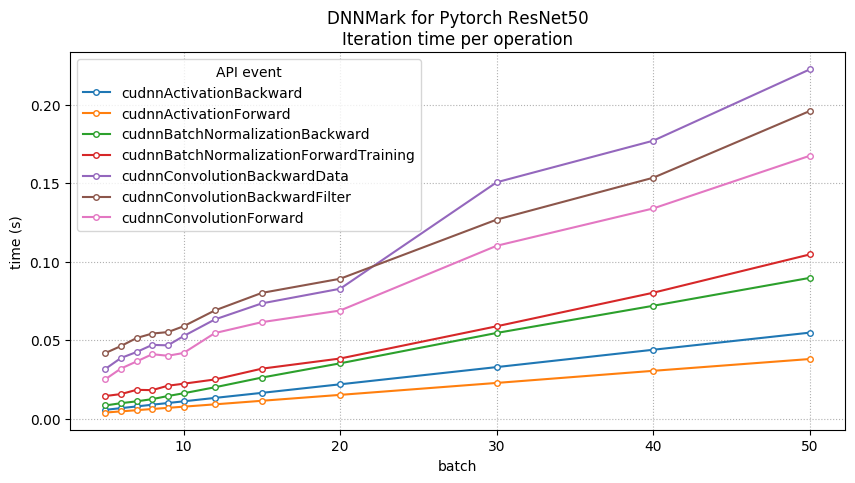

In [97]:
timesT = times.pivot_table(columns='API event', index='batch', values='time',aggfunc='sum')
display(timesT.head())
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
timesT.plot(marker='o', ms=4, mfc='w', ax=ax)
ax.grid(ls=':', which='major')
ax.grid(ls=':', lw=0.5, which='minor')
plt.title('DNNMark for Pytorch ResNet50\nIteration time per operation')
ax.set_ylabel('time (s)')
plt.show()

In [90]:
# Group API events by type
def getType(e):
    types = {'RELU': 'activation',
             'conv': 'conv',
             'BN': 'batchnormalization'}
    for k, v in types.items():
        m = re.search(v, e.lower())
        if m is not None:
            return k
    return 'other'

In [91]:
# Sum time for same type events
times['type'] = times['API event'].apply(getType)
times = times[(times['type'] != 'other')]
times = times.groupby(['type', 'batch'], as_index=False).sum()
times['batch'] = times['batch'].astype(int)
times.head()
times.sample(n=7)

,type,batch,time
3,BN,8,0.030457
4,BN,9,0.035240
5,BN,10,0.038272
27,conv,8,0.142034
21,RELU,30,0.055456
10,BN,40,0.151977
12,RELU,5,0.009347


In [92]:
timesT = times.pivot_table(columns='type', index='batch', values='time')
timesT.head()

type,BN,RELU,conv
batch,,,
5,0.022664,0.009347,0.098223
6,0.025349,0.011178,0.116581
7,0.029234,0.013020,0.129995
8,0.030457,0.014890,0.142034
9,0.035240,0.016692,0.141695


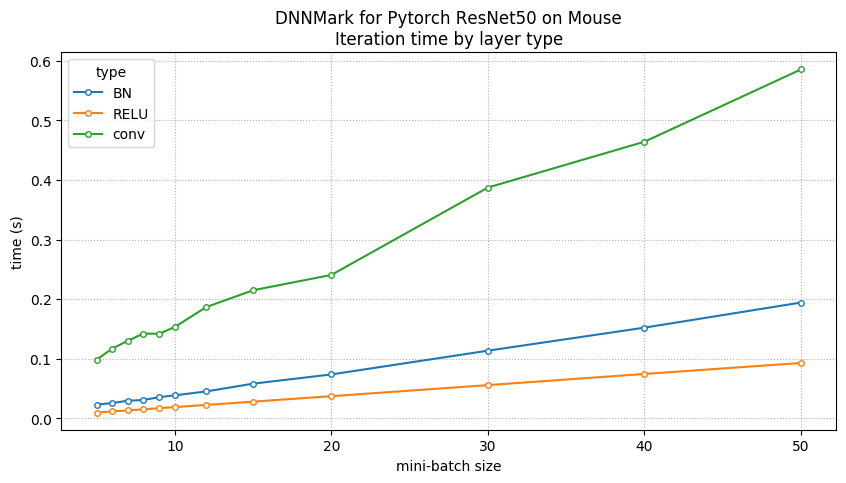

In [93]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
timesT.plot(marker='o', ms=4, mfc='w', ax=ax)
ax.grid(ls=':', which='major')
ax.grid(ls=':', lw=0.5, which='minor')
ax.set_xlabel('mini-batch size')
ax.set_ylabel('time (s)')
plt.title('DNNMark for Pytorch ResNet50 on Mouse\nIteration time by layer type')
plt.show()